In [3]:
import h5py
import numpy as np

mat_file = r'D:\BTP\sub-1_ses-1_task-bcimici_meg.mat'

with h5py.File(mat_file, 'r') as f:
    print("Keys in the .mat file:")
    for key in f.keys():
        print("-", key)

    # Example: Access 'dataMAT' struct
    dataMAT = f['dataMAT']
    print("\nFields in 'dataMAT':")
    for field in dataMAT:
        print("-", field)


Keys in the .mat file:
- #refs#
- dataMAT

Fields in 'dataMAT':
- fsample
- grad
- label
- time
- trial
- trialclass
- trialinfo


In [10]:
import h5py
import numpy as np

mat_file = r'D:\BTP\sub-1_ses-1_task-bcimici_meg.mat'

with h5py.File(mat_file, 'r') as f:
    data = f['dataMAT']

    # --- trialinfo ---
    trialinfo = np.array(data['trialinfo']).T
    print(f"Trialinfo shape: {trialinfo.shape}")
    print(f"First 5 entries:\n{trialinfo[:5]}")

    # --- Trials ---
    trials = []
    trial_ref = data['trial'][0, 0]  # Single reference
    trial_cell = f[trial_ref]       # Dereference into cell array

    for i in range(trial_cell.shape[1]):
        ref = trial_cell[0, i]
        if isinstance(ref, h5py.Reference):
            trial_data = f[ref][()]
            trials.append(trial_data)

    print(f"Loaded {len(trials)} trials. Shape of first trial: {trials[0].shape}")

    # --- Time vectors ---
    times = []
    time_ref = data['time'][0, 0]   # Single reference
    time_cell = f[time_ref]         # Dereference into cell array

    for i in range(time_cell.shape[1]):
        ref = time_cell[0, i]
        if isinstance(ref, h5py.Reference):
            time_data = f[ref][()]
            times.append(time_data)

    print(f"Loaded {len(times)} time vectors. Length of first: {len(times[0])}")


Trialinfo shape: (200, 1)
First 5 entries:
[[1.]
 [1.]
 [1.]
 [1.]
 [2.]]


IndexError: list index out of range

In [2]:

from scipy.io import loadmat
import numpy as np
import os

# Set path to your .mat file (make sure it's in the same directory)
mat_file = r'D:\\BTP\\sub-1_ses-1_task-bcimici_meg.mat'

# Load .mat file
if os.path.exists(mat_file):
    data = loadmat(mat_file)['dataMAT']
    
    # Extract fields from MATLAB struct
    trials = [data['trial'][0, 0][i][0] for i in range(data['trial'][0, 0].shape[0])]
    time = [data['time'][0, 0][i][0] for i in range(data['time'][0, 0].shape[0])]
    labels = [str(l[0]) for l in data['label'][0, 0][0]]
    fsample = float(data['fsample'][0, 0][0, 0])

    print(f"Loaded {len(trials)} trials with {trials[0].shape[0]} channels and {trials[0].shape[1]} samples each.")
    print("Channel Labels:", labels)
    print("Sampling Frequency:", fsample)
else:
    print("MAT file not found. Please place it in the same directory.")


NotImplementedError: Please use HDF reader for matlab v7.3 files, e.g. h5py

In [1]:
import numpy as np
from scipy.fftpack import fft, ifft, fftshift, ifftshift

def MVMD(signal, alpha, tau, K, DC, init, tol):
    x, y = signal.shape
    if x > y:
        C = y
        signal = signal.T
    else:
        C = x

    T = signal.shape[1]
    t = np.arange(1, T + 1) / T
    freqs = t - 0.5 - 1 / T

    # FFT of the signal
    f_hat = fftshift(fft(signal, axis=1))
    f_hat_plus = f_hat.copy()
    f_hat_plus[:, :T//2] = 0  # Set the negative frequencies to zero

    # Initialization
    N = 500
    Alpha = alpha * np.ones(K)
    u_hat_plus = np.zeros((N, len(freqs), K, C), dtype=complex)
    omega_plus = np.zeros((N, K))

    if init == 1:
        omega_plus[0, :] = (0.5 / K) * np.arange(K)
    elif init == 2:
        omega_plus[0, :] = np.sort(np.exp(np.log(1 / T) + (np.log(0.5) - np.log(1 / T)) * np.random.rand(K)))
    else:
        omega_plus[0, :] = 0

    if DC:
        omega_plus[0, 0] = 0

    lambda_hat = np.zeros((N, len(freqs), C), dtype=complex)
    uDiff = tol + np.finfo(float).eps
    n = 0
    sum_uk = np.zeros((C, len(freqs)), dtype=complex)

    # Main algorithm
    while uDiff > tol and n < N:
        k = 0
        for c in range(C):
            sum_uk[c, :] = u_hat_plus[n, :, K-1, c] + sum_uk[c, :] - u_hat_plus[n, :, k, c]
            u_hat_plus[n+1, :, k, c] = (f_hat_plus[c, :] - sum_uk[c, :] - lambda_hat[n, :, c] / 2) / (1 + Alpha[k] * (freqs - omega_plus[n, k])**2)

        if not DC:
            temp1 = 0
            temp2 = 0
            for c in range(C):
                numerator = np.sum(freqs * np.abs(u_hat_plus[n+1, :, k, c])**2)
                denominator = np.sum(np.abs(u_hat_plus[n+1, :, k, c])**2)
                temp1 += numerator
                temp2 += denominator
            omega_plus[n+1, k] = temp1 / temp2

        for k in range(1, K):
            for c in range(C):
                sum_uk[c, :] = u_hat_plus[n+1, :, k-1, c] + sum_uk[c, :] - u_hat_plus[n, :, k, c]
                u_hat_plus[n+1, :, k, c] = (f_hat_plus[c, :] - sum_uk[c, :] - lambda_hat[n, :, c] / 2) / \
                                          (1 + Alpha[k] * (freqs - omega_plus[n, k])**2)

            temp1 = 0
            temp2 = 0
            for c in range(C):
                numerator = np.sum(freqs * np.abs(u_hat_plus[n+1, :, k, c])**2)
                denominator = np.sum(np.abs(u_hat_plus[n+1, :, k, c])**2)
                temp1 += numerator
                temp2 += denominator
            omega_plus[n+1, k] = temp1 / temp2

        for c in range(C):
            lambda_hat[n+1, :, c] = lambda_hat[n, :, c] + tau * (np.sum(u_hat_plus[n+1, :, :, c], axis=1) - f_hat_plus[c, :])

        n += 1

        uDiff = np.finfo(float).eps
        for i in range(K):
            for c in range(C):
                uDiff += np.sum((u_hat_plus[n, :, i, c] - u_hat_plus[n-1, :, i, c]) * \
                                np.conj(u_hat_plus[n, :, i, c] - u_hat_plus[n-1, :, i, c]))
        uDiff = np.abs(uDiff)

    N = min(N, n)
    omega = omega_plus[:N, :]

    u_hat = np.zeros((T, K, C), dtype=complex)
    for c in range(C):
        u_hat[:, :, c] = u_hat_plus[N, :, :, c]

    u = np.zeros((K, T, C))
    for k in range(K):
        for c in range(C):
            u[k, :, c] = np.real(ifft(ifftshift(u_hat[:, k, c])))

    u_hat = np.zeros((len(freqs), K, C), dtype=complex)
    for k in range(K):
        for c in range(C):
            u_hat[:, k, c] = fftshift(fft(u[k, :, c]))

    u_hat = np.transpose(u_hat, (1, 0, 2))

    return u, u_hat, omega


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat

In [4]:
# Load data from MATLAB file
data = loadmat("/content/drive/MyDrive/data_mul.mat")
X = data['data_mul'].T[:256]

In [5]:
X.shape

(256, 32)

In [22]:
# Parameters
alpha = 2000
tau = 0
K = 10
DC = True
init = 1
tol = 1e-6

# Generate a sample multivariate signal
L = X.shape[1]
C = X.shape[0]
#signal = np.sin(np.random.randn(C, L))
signal=X.T
# Call MVMD
u, u_hat, omega = MVMD(signal, alpha, tau, K, DC, init, tol)

In [23]:
u.shape

(10, 256, 32)

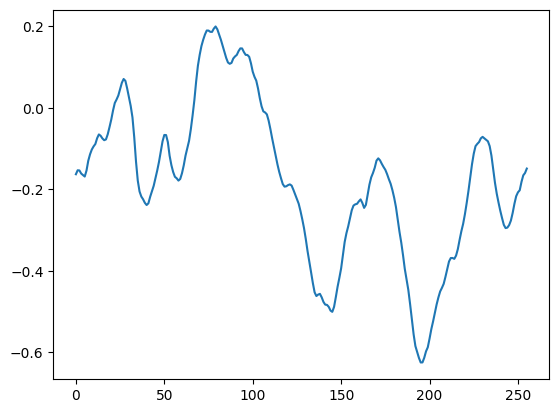

In [32]:
import matplotlib.pyplot as plt
plt.plot(u[0,:,30])